In [124]:
import pandas as pd
import numpy as np
import holidays
import warnings
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

## check for the sumup

In [140]:
historical_df = pd.read_excel(r'data\United Historical Hourly Load-2013-2022.xlsx')
historical_df.drop(columns = ['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], inplace = True)
historical_df

,Year,MONTH,DAY,TIME,Load,MW
0,2013,1,1,01:00:00,158438.0,158.438
1,2013,1,1,02:00:00,152643.0,152.643
2,2013,1,1,03:00:00,149105.0,149.105
3,2013,1,1,04:00:00,147235.0,147.235
4,2013,1,1,05:00:00,146788.0,146.788
...,...,...,...,...,...,...
87642,2022,12,31,19:00:00,413063.0,413.063
87643,2022,12,31,20:00:00,404533.0,404.533
87644,2022,12,31,21:00:00,395172.0,395.172
87645,2022,12,31,22:00:00,387412.0,387.412


In [146]:
# sum up the MW values for each year
yearly_sum = historical_df.groupby('Year')['MW'].sum().reset_index()
# Display the result
yearly_sum.rename(columns = {'MW':'value calculated'}, inplace = True)

In [147]:
real_df = {
    "year": [2018, 2019, 2020, 2021, 2022],
    "united_report": [2447189, 2739378, 2871674, 2902460, 2993636],
}
real_df = pd.DataFrame.from_dict(real_df)
# combine the yearly_sum to real_df
real_df = pd.merge(real_df, yearly_sum, how='left', left_on='year', right_on = 'Year')
real_df.drop(columns=['Year'], inplace=True)

In [148]:
real_df['ratio'] = real_df['united_report'] / real_df['value calculated']

In [149]:
real_df

,year,united_report,value calculated,ratio
0,2018,2447189,2.517293e+06,0.972151
1,2019,2739378,3.553970e+06,0.770794
2,2020,2871674,3.818834e+06,0.751977
3,2021,2902460,3.644419e+06,0.796412
4,2022,2993636,3.104588e+06,0.964262


# load data

In [183]:
df = pd.read_csv(r'data\UNITED_eeweather_data_1422.csv')

In [184]:
df

,Unnamed: 0,Year,MONTH,DAY,TIME,Load,MW,hour_begins,temp_f
0,13097,2014,6,30,18:00:00,308789.0,308.789,2014-06-30 18:00:00-06:00,81.75164
1,13098,2014,6,30,19:00:00,303820.0,303.820,2014-06-30 19:00:00-06:00,79.88504
2,13099,2014,6,30,20:00:00,290314.0,290.314,2014-06-30 20:00:00-06:00,74.40566
3,13100,2014,6,30,21:00:00,269876.0,269.876,2014-06-30 21:00:00-06:00,69.23264
4,13101,2014,6,30,22:00:00,257788.0,257.788,2014-06-30 22:00:00-06:00,63.74084
...,...,...,...,...,...,...,...,...,...
72988,87619,2022,12,30,20:00:00,417765.0,417.765,2022-12-30 20:00:00-07:00,18.59000
72989,87620,2022,12,30,21:00:00,412312.0,412.312,2022-12-30 21:00:00-07:00,16.90394
72990,87621,2022,12,30,22:00:00,404261.0,404.261,2022-12-30 22:00:00-07:00,18.84506
72991,87622,2022,12,30,23:00:00,392621.0,392.621,2022-12-30 23:00:00-07:00,17.73950


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72993 entries, 0 to 72992
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   72993 non-null  int64  
 1   Year         72993 non-null  int64  
 2   MONTH        72993 non-null  int64  
 3   DAY          72993 non-null  int64  
 4   TIME         72993 non-null  object 
 5   Load         72993 non-null  float64
 6   MW           72993 non-null  float64
 7   hour_begins  72993 non-null  object 
 8   temp_f       72993 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 5.0+ MB


In [186]:
# strip 2014-06-30 18:00:00-06:00 into 2014-06-30 18:00:00
df['hour_begins'] = df['hour_begins'].str.slice(0, 19)
df['hour_begins'] = pd.to_datetime(df['hour_begins'])

In [187]:
print(f'The start datetime is {df['hour_begins'].min()}')
print(f'The end datetime is {df['hour_begins'].max()}')

The start datetime is 2014-06-30 18:00:00
The end datetime is 2022-12-31 00:00:00


In [188]:
# rename 
df =df.rename(columns = {'MW':'gross_load','Year':'year', 'MONTH': 'month', 'DAY':'date'})
# from TIME 18:00:00 to get 18 only
df['hour'] = df['TIME'].str.slice(0, 2).astype(int)
df.drop(columns = ['Unnamed: 0',  'Load', 'TIME' ], inplace = True)

In [189]:
# add a column named ratio from real_df, group by Year
df = df.merge(real_df[['year', 'ratio']], on='year', how='left')
# if ratio is not na, then gross_load * ratio
df['gross_load'] = np.where(df['ratio'].notna(), df['gross_load'] * df['ratio'], df['gross_load'])
df

,year,month,date,gross_load,hour_begins,temp_f,hour,ratio
0,2014,6,30,308.789000,2014-06-30 18:00:00,81.75164,18,NaN
1,2014,6,30,303.820000,2014-06-30 19:00:00,79.88504,19,NaN
2,2014,6,30,290.314000,2014-06-30 20:00:00,74.40566,20,NaN
3,2014,6,30,269.876000,2014-06-30 21:00:00,69.23264,21,NaN
4,2014,6,30,257.788000,2014-06-30 22:00:00,63.74084,22,NaN
...,...,...,...,...,...,...,...,...
72988,2022,12,30,402.834928,2022-12-30 20:00:00,18.59000,20,0.964262
72989,2022,12,30,397.576807,2022-12-30 21:00:00,16.90394,21,0.964262
72990,2022,12,30,389.813533,2022-12-30 22:00:00,18.84506,22,0.964262
72991,2022,12,30,378.589523,2022-12-30 23:00:00,17.73950,23,0.964262


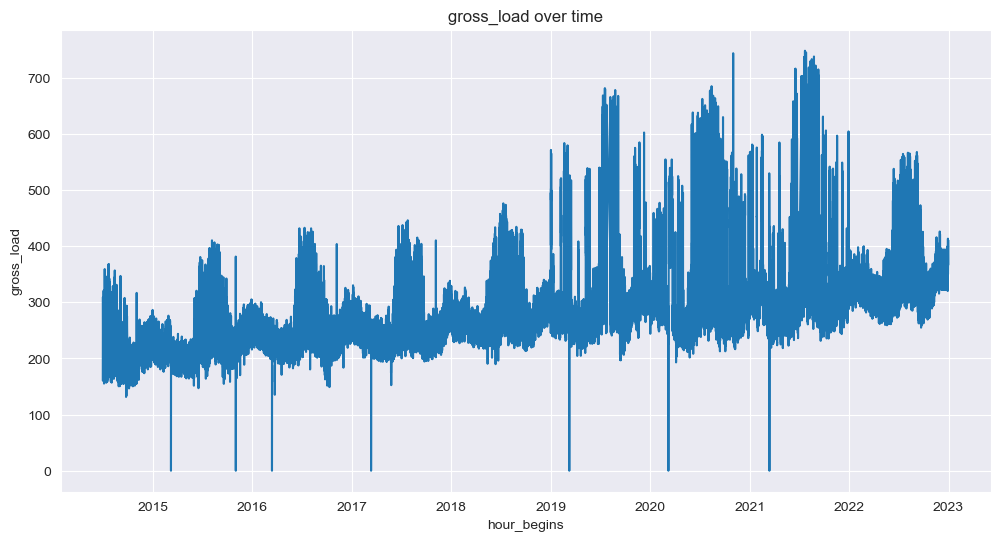

In [190]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being hour_begins
plt.figure(figsize=(12, 6))
plt.plot(df['hour_begins'], df['gross_load'])
plt.title('gross_load over time')
plt.xlabel('hour_begins')
plt.ylabel('gross_load')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of outliers: 1460


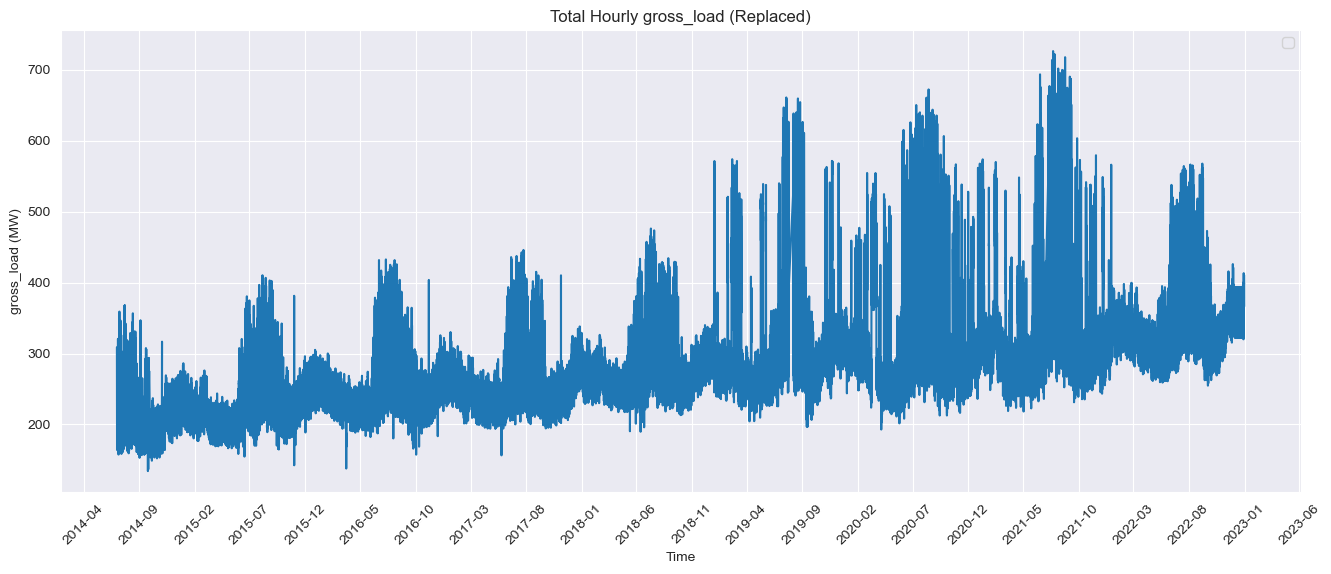

In [191]:
# replace the outlier values as the average of the previous day and the next day
def replace_outliers_with_avg(s):
    lower_bound = s.quantile(0.01)
    upper_bound = s.quantile(0.99)
    outliers = (s < lower_bound) | (s > upper_bound)
    
    for idx in s[outliers].index:
        if idx == 0 or idx == len(s) - 1:
            # directly drop the first and last value
            s.at[idx] = np.nan
            continue
        prev_val = s.iloc[idx - 1]
        next_val = s.iloc[idx + 1]
        s.at[idx] = (prev_val + next_val) / 2
    return s

# reset index 
df.reset_index(drop=True, inplace=True)
# Assuming df is your DataFrame and 'hour_begins' and 'gross_load' are the relevant columns
df['gross_load_replaced'] = replace_outliers_with_avg(df['gross_load'].copy())

# Number of outliers
print(f'Number of outliers: {df[df["gross_load"] != df["gross_load_replaced"]].shape[0]}')

# Plot the replaced 'gross_load_replaced'
plt.figure(figsize=(16, 6))
plt.plot(df['hour_begins'], df['gross_load_replaced'])
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()
# Set date format on x-axis every 5 month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


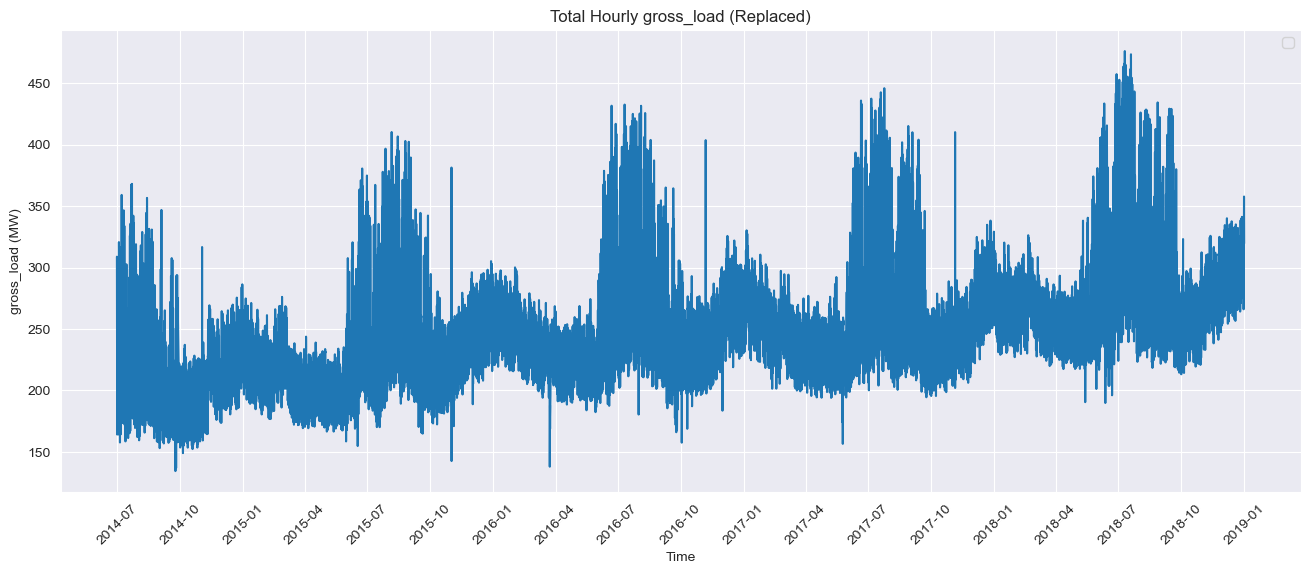

In [192]:
test = df[df['hour_begins'] <= '2018-12-31 23:00']

# Plot the replaced 'gross_load_replaced'
plt.figure(figsize=(16, 6))
plt.plot(test['hour_begins'], test['gross_load_replaced'])
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()
# Set date format on x-axis every 5 month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()


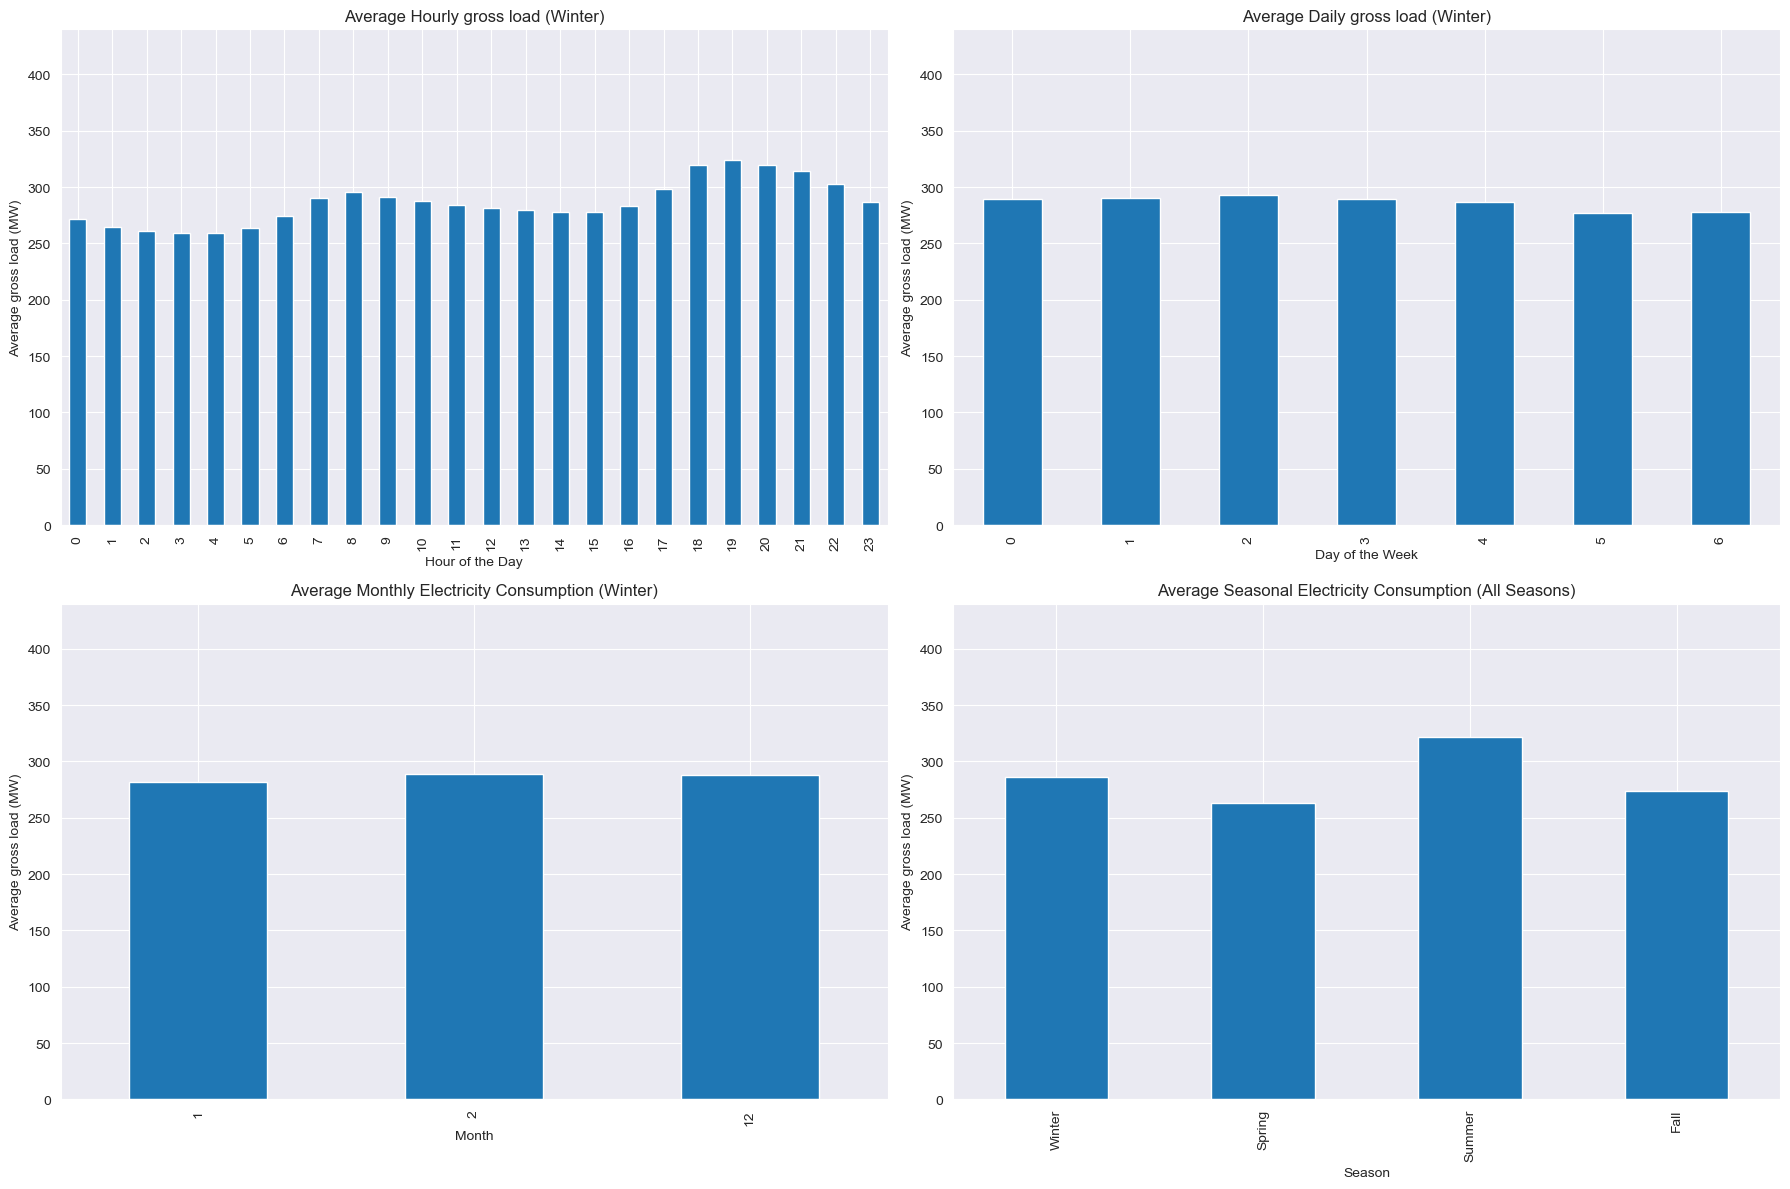

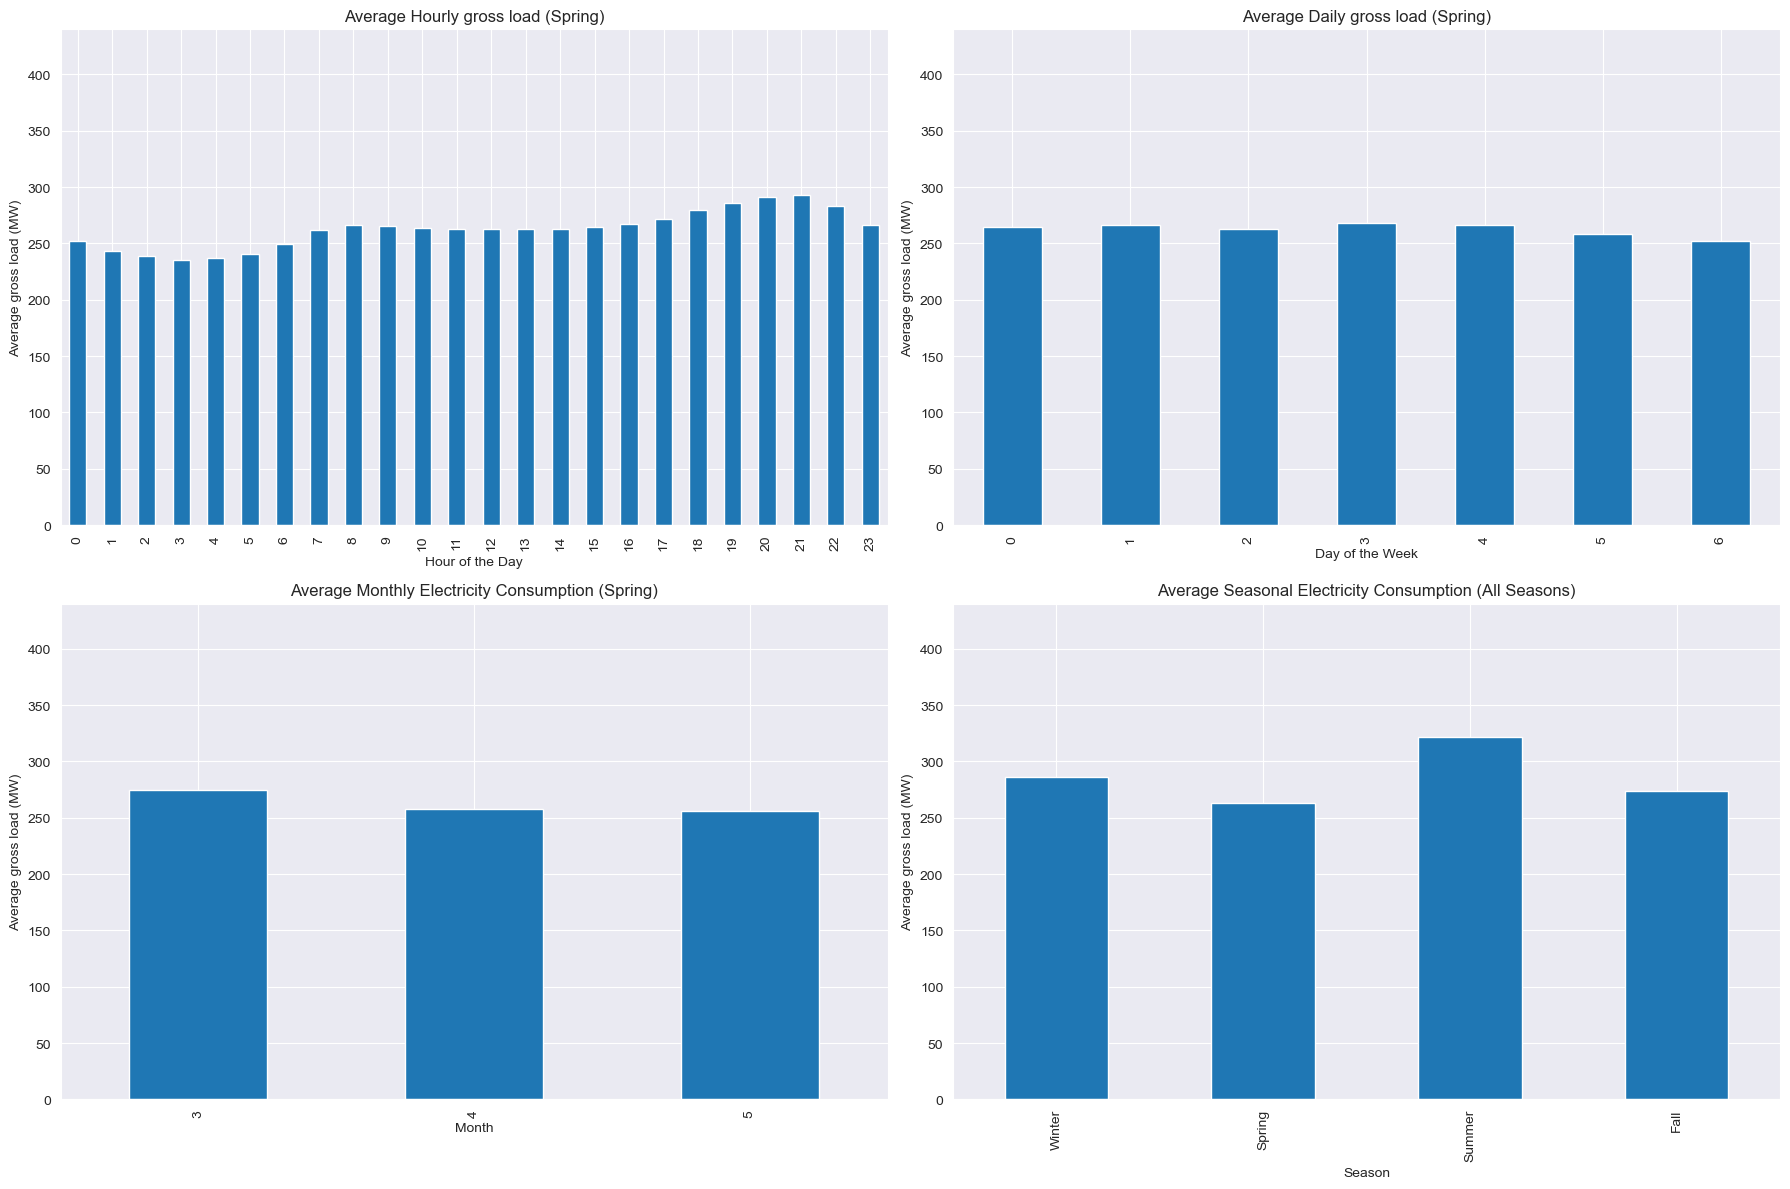

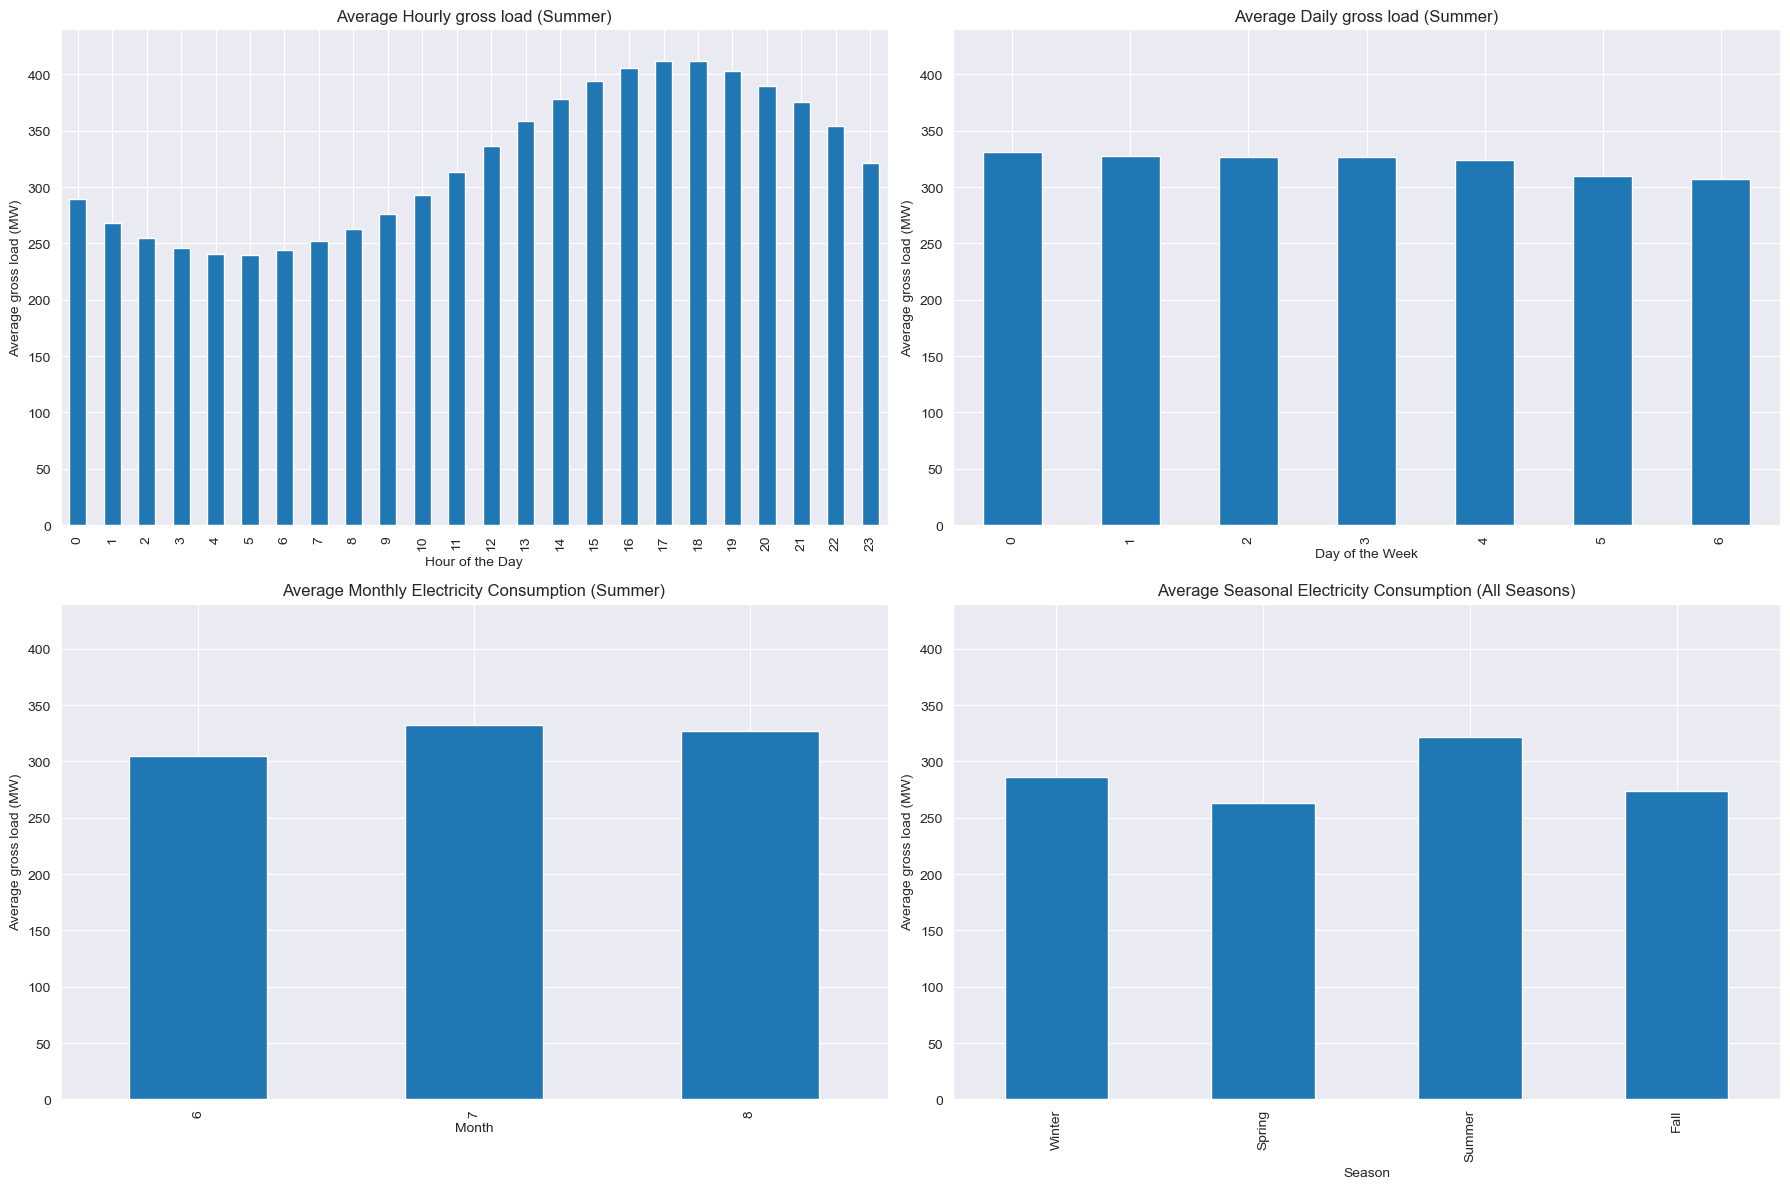

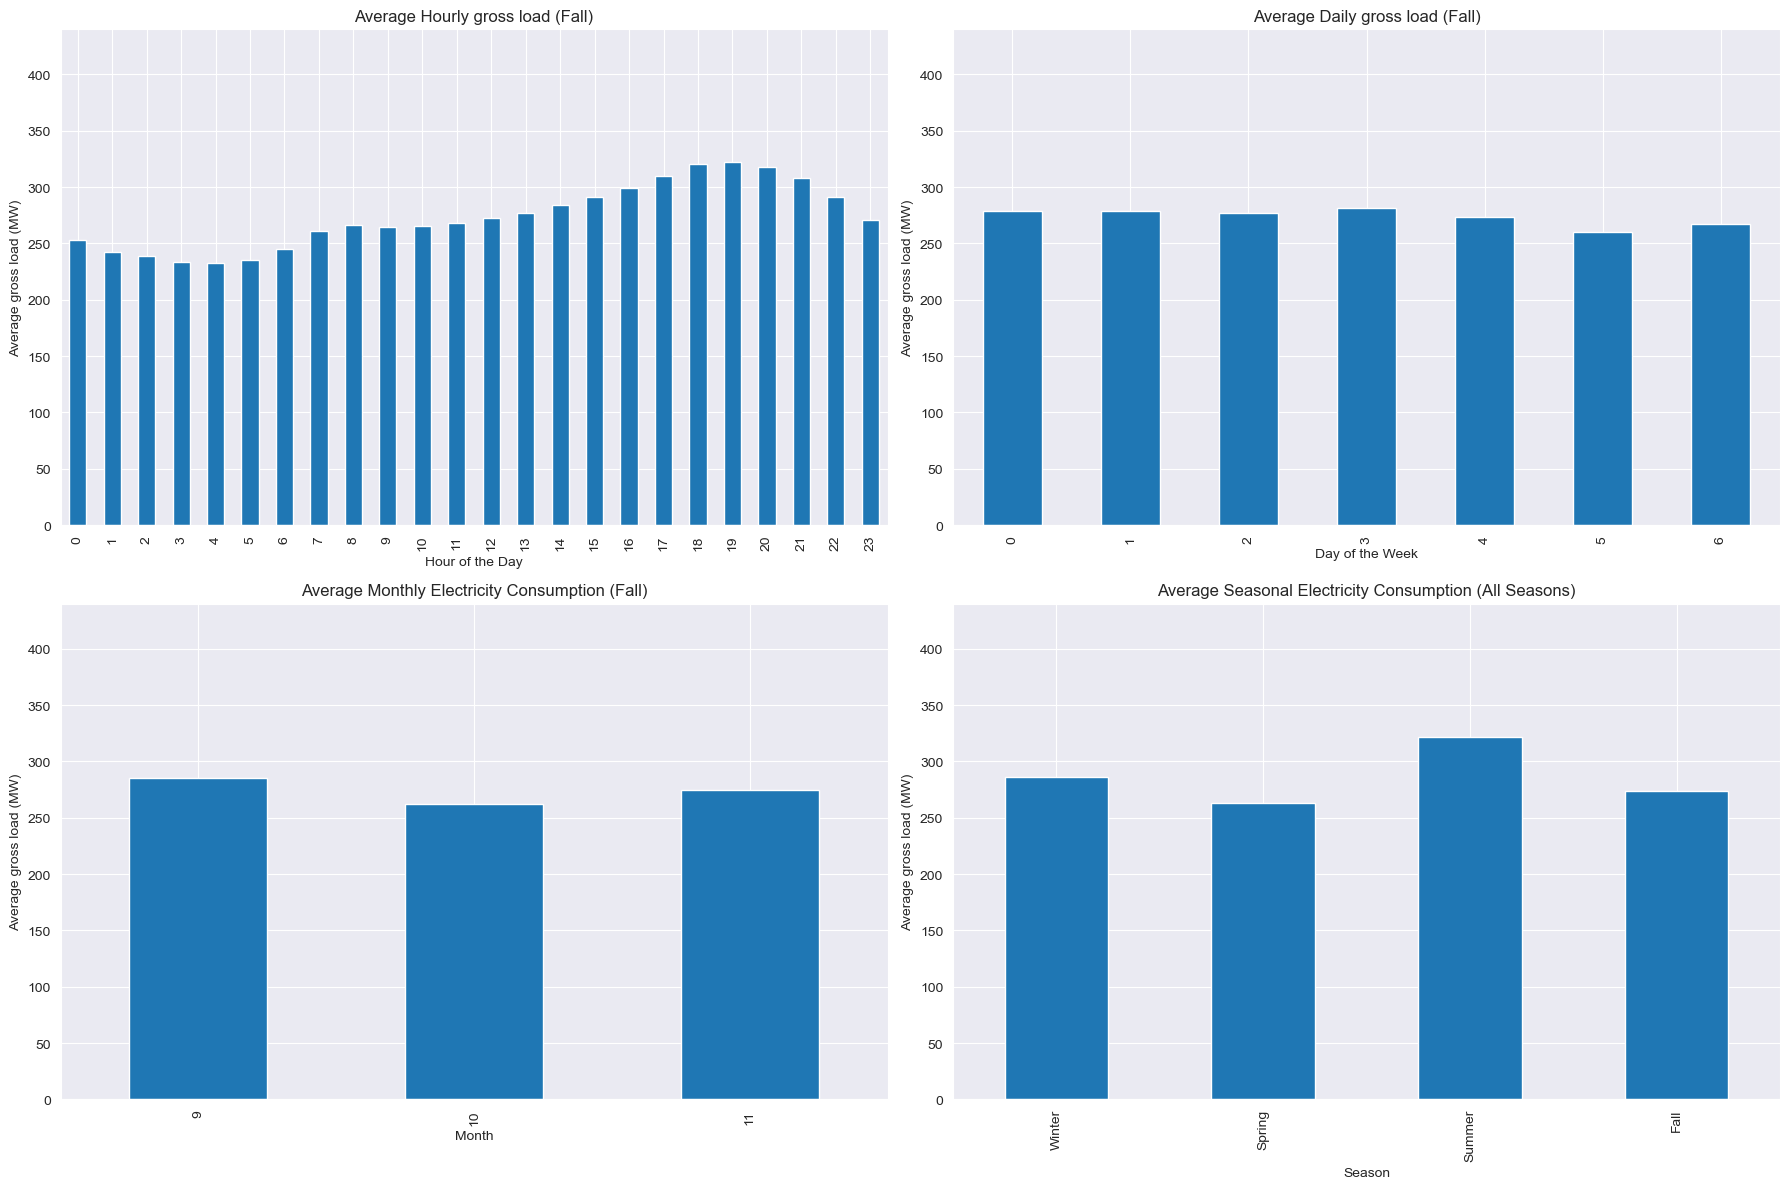

In [194]:
def plot_data(df):
    df = df.sort_values(by='hour_begins')

    # Ensure necessary time features are added
    df['hour'] = df['hour_begins'].dt.hour
    df['day_of_week'] = df['hour_begins'].dt.dayofweek
    df['month'] = df['hour_begins'].dt.month

    # Define seasons
    df['season'] = df['hour_begins'].dt.month % 12 // 3 + 1
    season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df['season'] = df['season'].map(season_mapping)

    # Calculate seasonal consumption for all seasons
    season_consumption = df.groupby('season')['gross_load'].mean().reindex(season_mapping.values())

    # Function to plot data for a given season
    def plot_season_data(season_df, season_name, season_consumption, axs, y_limit):
        # Plot by hour of the day
        hourly_consumption = season_df.groupby('hour')['gross_load'].mean()
        hourly_consumption.plot(kind='bar', ax=axs[0, 0])
        axs[0, 0].set_xlabel('Hour of the Day')
        axs[0, 0].set_ylabel('Average gross load (MW)')
        axs[0, 0].set_title(f'Average Hourly gross load ({season_name})')
        axs[0, 0].set_ylim(0, y_limit)

        # Plot by day of the week
        daily_consumption = season_df.groupby('day_of_week')['gross_load'].mean()
        daily_consumption.plot(kind='bar', ax=axs[0, 1])
        axs[0, 1].set_xlabel('Day of the Week')
        axs[0, 1].set_ylabel('Average gross load (MW)')
        axs[0, 1].set_title(f'Average Daily gross load ({season_name})')
        axs[0, 1].set_ylim(0, y_limit)

        # Plot by month within the season
        monthly_consumption = season_df.groupby('month')['gross_load'].mean()
        monthly_consumption.plot(kind='bar', ax=axs[1, 0])
        axs[1, 0].set_xlabel('Month')
        axs[1, 0].set_ylabel('Average gross load (MW)')
        axs[1, 0].set_title(f'Average Monthly Electricity Consumption ({season_name})')
        axs[1, 0].set_ylim(0, y_limit)

        # Plot seasonal consumption for all seasons
        season_consumption.plot(kind='bar', ax=axs[1, 1])
        axs[1, 1].set_xlabel('Season')
        axs[1, 1].set_ylabel('Average gross load (MW)')
        axs[1, 1].set_title('Average Seasonal Electricity Consumption (All Seasons)')
        axs[1, 1].set_ylim(0, y_limit)

    # find out the y limit as the max average value of the gross load
    y_limit = df['gross_load'].mean() + 2 * df['gross_load'].std()


    # Plot for each season
    for season, season_name in season_mapping.items():
        season_df = df[df['season'] == season_name]
        if not season_df.empty:
            fig, axs = plt.subplots(2, 2, figsize=(18, 12))
            plot_season_data(season_df, season_name, season_consumption, axs, y_limit)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No data available for {season_name}")

plot_data(df)

## feature engineering

In [209]:
# feature engineering
df['month_sin'] = np.sin((df['month'] - 1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df['month'] - 1) * (2. * np.pi / 12))
df['day_sin'] = np.sin((df['date'] - 1) * (2. * np.pi / 31))
df['day_cos'] = np.cos((df['date'] - 1) * (2. * np.pi / 31))
df['hour_sin'] = np.sin(df['hour'] * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df['hour'] * (2. * np.pi / 24))
df['dow'] = df['hour_begins'].dt.dayofweek # 0 means monday
df['dow_sin'] = np.sin(df['dow'] * (2. * np.pi / 7))
df['dow_cos'] = np.cos(df['dow'] * (2. * np.pi / 7))

df['season'] = ['winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' for x in df['month']]

# holiday feature
us_holidays = holidays.US()
df['holiday'] = df['hour_begins'].apply(lambda x: x in us_holidays)
df['holiday'] = df['holiday'].astype(int)

In [210]:
df

,year,month,date,gross_load,hour_begins,temp_f,hour,ratio,gross_load_replaced,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dow,dow_sin,dow_cos,season,holiday
0,2014,6,30,308.789000,2014-06-30 18:00:00,81.75164,18,NaN,308.789000,0.5,-0.866025,-0.394356,0.918958,-1.000000,-1.836970e-16,0,0.000000,1.000000,summer,0
1,2014,6,30,303.820000,2014-06-30 19:00:00,79.88504,19,NaN,303.820000,0.5,-0.866025,-0.394356,0.918958,-0.965926,2.588190e-01,0,0.000000,1.000000,summer,0
2,2014,6,30,290.314000,2014-06-30 20:00:00,74.40566,20,NaN,290.314000,0.5,-0.866025,-0.394356,0.918958,-0.866025,5.000000e-01,0,0.000000,1.000000,summer,0
3,2014,6,30,269.876000,2014-06-30 21:00:00,69.23264,21,NaN,269.876000,0.5,-0.866025,-0.394356,0.918958,-0.707107,7.071068e-01,0,0.000000,1.000000,summer,0
4,2014,6,30,257.788000,2014-06-30 22:00:00,63.74084,22,NaN,257.788000,0.5,-0.866025,-0.394356,0.918958,-0.500000,8.660254e-01,0,0.000000,1.000000,summer,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72988,2022,12,30,402.834928,2022-12-30 20:00:00,18.59000,20,0.964262,402.834928,-0.5,0.866025,-0.394356,0.918958,-0.866025,5.000000e-01,4,-0.433884,-0.900969,winter,0
72989,2022,12,30,397.576807,2022-12-30 21:00:00,16.90394,21,0.964262,397.576807,-0.5,0.866025,-0.394356,0.918958,-0.707107,7.071068e-01,4,-0.433884,-0.900969,winter,0
72990,2022,12,30,389.813533,2022-12-30 22:00:00,18.84506,22,0.964262,389.813533,-0.5,0.866025,-0.394356,0.918958,-0.500000,8.660254e-01,4,-0.433884,-0.900969,winter,0
72991,2022,12,30,378.589523,2022-12-30 23:00:00,17.73950,23,0.964262,378.589523,-0.5,0.866025,-0.394356,0.918958,-0.258819,9.659258e-01,4,-0.433884,-0.900969,winter,0


In [211]:
# 3 days shift
df_ = df.copy()

# Calculate the hour_begins 3 days ago
df_['hour_begins_3d'] = df_['hour_begins'] - pd.Timedelta(days=3)
# Rename columns to avoid duplication
df_3d = df_[['hour_begins', 'gross_load_replaced']].copy()
df_3d.columns = ['hour_begins_3d', 'gross_load_replaced_3d']

# Merge the 3 days ago data with the original data
df_merged = df_.merge(df_3d, left_on='hour_begins_3d', right_on='hour_begins_3d', how='left')

# Display information about the merged DataFrame
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73001 entries, 0 to 73000
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   year                    73001 non-null  int64         
 1   month                   73001 non-null  int64         
 2   date                    73001 non-null  int64         
 3   gross_load              73001 non-null  float64       
 4   hour_begins             73001 non-null  datetime64[ns]
 5   temp_f                  73001 non-null  float64       
 6   hour                    73001 non-null  int32         
 7   ratio                   42739 non-null  float64       
 8   gross_load_replaced     73001 non-null  float64       
 9   month_sin               73001 non-null  float64       
 10  month_cos               73001 non-null  float64       
 11  day_sin                 73001 non-null  float64       
 12  day_cos                 73001 non-null  float6

In [212]:
df_merged[df_merged['gross_load_replaced_3d'].isnull()]

,year,month,date,gross_load,hour_begins,temp_f,hour,ratio,gross_load_replaced,month_sin,...,day_cos,hour_sin,hour_cos,dow,dow_sin,dow_cos,season,holiday,hour_begins_3d,gross_load_replaced_3d
0,2014,6,30,308.789000,2014-06-30 18:00:00,81.75164,18,NaN,308.789000,0.5,...,0.918958,-1.000000,-1.836970e-16,0,0.000000,1.00000,summer,0,2014-06-27 18:00:00,NaN
1,2014,6,30,303.820000,2014-06-30 19:00:00,79.88504,19,NaN,303.820000,0.5,...,0.918958,-0.965926,2.588190e-01,0,0.000000,1.00000,summer,0,2014-06-27 19:00:00,NaN
2,2014,6,30,290.314000,2014-06-30 20:00:00,74.40566,20,NaN,290.314000,0.5,...,0.918958,-0.866025,5.000000e-01,0,0.000000,1.00000,summer,0,2014-06-27 20:00:00,NaN
3,2014,6,30,269.876000,2014-06-30 21:00:00,69.23264,21,NaN,269.876000,0.5,...,0.918958,-0.707107,7.071068e-01,0,0.000000,1.00000,summer,0,2014-06-27 21:00:00,NaN
4,2014,6,30,257.788000,2014-06-30 22:00:00,63.74084,22,NaN,257.788000,0.5,...,0.918958,-0.500000,8.660254e-01,0,0.000000,1.00000,summer,0,2014-06-27 22:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72861,2022,12,25,328.397756,2022-12-25 05:00:00,21.47900,5,0.964262,328.397756,-0.5,...,0.151428,0.965926,2.588190e-01,6,-0.781831,0.62349,winter,1,2022-12-22 05:00:00,NaN
72862,2022,12,25,341.434579,2022-12-25 06:00:00,25.37456,6,0.964262,341.434579,-0.5,...,0.151428,1.000000,6.123234e-17,6,-0.781831,0.62349,winter,1,2022-12-22 06:00:00,NaN
72863,2022,12,25,354.967032,2022-12-25 07:00:00,30.92756,7,0.964262,354.967032,-0.5,...,0.151428,0.965926,-2.588190e-01,6,-0.781831,0.62349,winter,1,2022-12-22 07:00:00,NaN
72864,2022,12,25,359.789306,2022-12-25 08:00:00,46.68656,8,0.964262,359.789306,-0.5,...,0.151428,0.866025,-5.000000e-01,6,-0.781831,0.62349,winter,1,2022-12-22 08:00:00,NaN


In [213]:
# df_merged drop nan
df_merged.drop(columns = ['ratio'], inplace = True)
df_merged.dropna(inplace=True)
print(df_merged.columns)
# time stamp min and max
print(f'\nThe start hour_begins is: {df_merged['hour_begins'].min()}')
print(f'The end hour_begins is: {df_merged['hour_begins'].max()}\n')

print(df_merged.info())

Index(['year', 'month', 'date', 'gross_load', 'hour_begins', 'temp_f', 'hour',
       'gross_load_replaced', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'dow', 'dow_sin', 'dow_cos', 'season',
       'holiday', 'hour_begins_3d', 'gross_load_replaced_3d'],
      dtype='object')

The start hour_begins is: 2014-07-03 18:00:00
The end hour_begins is: 2022-12-31 00:00:00

<class 'pandas.core.frame.DataFrame'>
Index: 71671 entries, 72 to 73000
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   year                    71671 non-null  int64         
 1   month                   71671 non-null  int64         
 2   date                    71671 non-null  int64         
 3   gross_load              71671 non-null  float64       
 4   hour_begins             71671 non-null  datetime64[ns]
 5   temp_f                  71671 non-null  float64       
 6   hour  

In [214]:
df_merged.columns

Index(['year', 'month', 'date', 'gross_load', 'hour_begins', 'temp_f', 'hour',
       'gross_load_replaced', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'dow', 'dow_sin', 'dow_cos', 'season',
       'holiday', 'hour_begins_3d', 'gross_load_replaced_3d'],
      dtype='object')

## preprocessing

In [394]:
# reorder the columns
column = ['hour_begins','gross_load_replaced_3d', 'year', 'month', 'dow',  'season', 'holiday','month_sin', 'month_cos', 'hour_sin', 'hour_cos','dow_sin', 'dow_cos', 'gross_load_replaced' ]
LSTM_df = df_merged[column]

In [395]:
LSTM_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71671 entries, 72 to 73000
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   hour_begins             71671 non-null  datetime64[ns]
 1   gross_load_replaced_3d  71671 non-null  float64       
 2   year                    71671 non-null  int64         
 3   month                   71671 non-null  int64         
 4   dow                     71671 non-null  int32         
 5   season                  71671 non-null  object        
 6   holiday                 71671 non-null  int32         
 7   month_sin               71671 non-null  float64       
 8   month_cos               71671 non-null  float64       
 9   hour_sin                71671 non-null  float64       
 10  hour_cos                71671 non-null  float64       
 11  dow_sin                 71671 non-null  float64       
 12  dow_cos                 71671 non-null  float64   

In [396]:
LSTM_df = pd.get_dummies(LSTM_df, columns=['season'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in LSTM_df.columns:
    if LSTM_df[col].dtype == 'bool':
        LSTM_df[col] = LSTM_df[col].astype(int)
# place the target variable at the last column
LSTM_df = LSTM_df[[c for c in LSTM_df if c not in ['gross_load_replaced']] + ['gross_load_replaced']]
LSTM_df

,hour_begins,gross_load_replaced_3d,year,month,dow,holiday,month_sin,month_cos,hour_sin,hour_cos,dow_sin,dow_cos,season_spring,season_summer,season_winter,gross_load_replaced
72,2014-07-03 18:00:00,308.789000,2014,7,3,0,1.224647e-16,-1.000000,-1.000000,-1.836970e-16,0.433884,-0.900969,0,1,0,315.169000
73,2014-07-03 19:00:00,303.820000,2014,7,3,0,1.224647e-16,-1.000000,-0.965926,2.588190e-01,0.433884,-0.900969,0,1,0,296.100000
74,2014-07-03 20:00:00,290.314000,2014,7,3,0,1.224647e-16,-1.000000,-0.866025,5.000000e-01,0.433884,-0.900969,0,1,0,280.782000
75,2014-07-03 21:00:00,269.876000,2014,7,3,0,1.224647e-16,-1.000000,-0.707107,7.071068e-01,0.433884,-0.900969,0,1,0,270.472000
76,2014-07-03 22:00:00,257.788000,2014,7,3,0,1.224647e-16,-1.000000,-0.500000,8.660254e-01,0.433884,-0.900969,0,1,0,264.949000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72996,2022-12-30 20:00:00,388.921591,2022,12,4,0,-5.000000e-01,0.866025,-0.866025,5.000000e-01,-0.433884,-0.900969,0,0,1,402.834928
72997,2022-12-30 21:00:00,382.628817,2022,12,4,0,-5.000000e-01,0.866025,-0.707107,7.071068e-01,-0.433884,-0.900969,0,0,1,397.576807
72998,2022-12-30 22:00:00,371.827154,2022,12,4,0,-5.000000e-01,0.866025,-0.500000,8.660254e-01,-0.433884,-0.900969,0,0,1,389.813533
72999,2022-12-30 23:00:00,357.522326,2022,12,4,0,-5.000000e-01,0.866025,-0.258819,9.659258e-01,-0.433884,-0.900969,0,0,1,378.589523


In [397]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
LSTM_df.iloc[:, 1:] = scaler.fit_transform(LSTM_df.iloc[:, 1:])
LSTM_df

,hour_begins,gross_load_replaced_3d,year,month,dow,holiday,month_sin,month_cos,hour_sin,hour_cos,dow_sin,dow_cos,season_spring,season_summer,season_winter,gross_load_replaced
72,2014-07-03 18:00:00,0.294800,0.0,0.545455,0.500000,0,0.50,0.000000,0.000000,0.500000,0.722521,5.551115e-17,0,1,0,0.305581
73,2014-07-03 19:00:00,0.286403,0.0,0.545455,0.500000,0,0.50,0.000000,0.017037,0.629410,0.722521,5.551115e-17,0,1,0,0.273358
74,2014-07-03 20:00:00,0.263581,0.0,0.545455,0.500000,0,0.50,0.000000,0.066987,0.750000,0.722521,5.551115e-17,0,1,0,0.247474
75,2014-07-03 21:00:00,0.229045,0.0,0.545455,0.500000,0,0.50,0.000000,0.146447,0.853553,0.722521,5.551115e-17,0,1,0,0.230052
76,2014-07-03 22:00:00,0.208619,0.0,0.545455,0.500000,0,0.50,0.000000,0.250000,0.933013,0.722521,5.551115e-17,0,1,0,0.220719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72996,2022-12-30 20:00:00,0.430207,1.0,1.000000,0.666667,0,0.25,0.933013,0.066987,0.750000,0.277479,0.000000e+00,0,0,1,0.453718
72997,2022-12-30 21:00:00,0.419574,1.0,1.000000,0.666667,0,0.25,0.933013,0.146447,0.853553,0.277479,0.000000e+00,0,0,1,0.444833
72998,2022-12-30 22:00:00,0.401321,1.0,1.000000,0.666667,0,0.25,0.933013,0.250000,0.933013,0.277479,0.000000e+00,0,0,1,0.431714
72999,2022-12-30 23:00:00,0.377149,1.0,1.000000,0.666667,0,0.25,0.933013,0.370590,0.982963,0.277479,0.000000e+00,0,0,1,0.412748


In [398]:
LSTM_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71671 entries, 72 to 73000
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   hour_begins             71671 non-null  datetime64[ns]
 1   gross_load_replaced_3d  71671 non-null  float64       
 2   year                    71671 non-null  float64       
 3   month                   71671 non-null  float64       
 4   dow                     71671 non-null  float64       
 5   holiday                 71671 non-null  int32         
 6   month_sin               71671 non-null  float64       
 7   month_cos               71671 non-null  float64       
 8   hour_sin                71671 non-null  float64       
 9   hour_cos                71671 non-null  float64       
 10  dow_sin                 71671 non-null  float64       
 11  dow_cos                 71671 non-null  float64       
 12  season_spring           71671 non-null  int32     

In [399]:
# only leave the data before 2019
LSTM_df = LSTM_df[LSTM_df['hour_begins']<='2018-12-31 23:00:00']
LSTM_df

,hour_begins,gross_load_replaced_3d,year,month,dow,holiday,month_sin,month_cos,hour_sin,hour_cos,dow_sin,dow_cos,season_spring,season_summer,season_winter,gross_load_replaced
72,2014-07-03 18:00:00,0.294800,0.0,0.545455,0.5,0,0.50,0.000000,0.000000,0.500000,0.722521,5.551115e-17,0,1,0,0.305581
73,2014-07-03 19:00:00,0.286403,0.0,0.545455,0.5,0,0.50,0.000000,0.017037,0.629410,0.722521,5.551115e-17,0,1,0,0.273358
74,2014-07-03 20:00:00,0.263581,0.0,0.545455,0.5,0,0.50,0.000000,0.066987,0.750000,0.722521,5.551115e-17,0,1,0,0.247474
75,2014-07-03 21:00:00,0.229045,0.0,0.545455,0.5,0,0.50,0.000000,0.146447,0.853553,0.722521,5.551115e-17,0,1,0,0.230052
76,2014-07-03 22:00:00,0.208619,0.0,0.545455,0.5,0,0.50,0.000000,0.250000,0.933013,0.722521,5.551115e-17,0,1,0,0.220719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38929,2018-12-31 19:00:00,0.339321,0.5,1.000000,0.0,0,0.25,0.933013,0.017037,0.629410,0.500000,1.000000e+00,0,0,1,0.367272
38930,2018-12-31 20:00:00,0.340384,0.5,1.000000,0.0,0,0.25,0.933013,0.066987,0.750000,0.500000,1.000000e+00,0,0,1,0.351441
38931,2018-12-31 21:00:00,0.331336,0.5,1.000000,0.0,0,0.25,0.933013,0.146447,0.853553,0.500000,1.000000e+00,0,0,1,0.339201
38932,2018-12-31 22:00:00,0.317460,0.5,1.000000,0.0,0,0.25,0.933013,0.250000,0.933013,0.500000,1.000000e+00,0,0,1,0.328249


In [400]:
# plot

## dividing the dataset

In [401]:
years_of_data = len(LSTM_df) / (365 * 24)
print(f'Total years of data: {years_of_data}')

Total years of data: 4.373401826484018


In [402]:
LSTM_df = LSTM_df.sort_values(by = 'hour_begins', ascending = True)
# out of sample data: final 1 years
ofs_number = 365 *12
LSTM_df_ofs = LSTM_df.iloc[-ofs_number:, :]
LSTM_df = LSTM_df.iloc[:-ofs_number, :]
print(f'start date of out of sample data: {LSTM_df_ofs["hour_begins"].min()}')
print(f'end date of out of sample data: {LSTM_df_ofs["hour_begins"].max()}')

start date of out of sample data: 2018-06-26 04:00:00
end date of out of sample data: 2018-12-31 23:00:00


In [403]:
print(f'Total number of days for training: {LSTM_df.shape[0]}')

Total number of days for training: 33931


In [404]:
LSTM_df = LSTM_df.sort_values(by='hour_begins')
values = LSTM_df.drop(columns='hour_begins').values
hour_begins = LSTM_df['hour_begins']

# out of sample data: total length multiplies 0.3
n_train_hours = int(values.shape[0] * 0.8)
# in sample data: the rest of the data
train = values[:n_train_hours, :]
train_timestamps = hour_begins[:n_train_hours]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of training data: {train.shape[0]}\n')

test = values[n_train_hours:, : ]
test_timestamps = hour_begins[n_train_hours:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of testing data: {test.shape[0]}')

min: 2014-07-03 18:00:00
max: 2017-09-14 06:00:00
length of training data: 27144

min: 2017-09-14 07:00:00
max: 2018-06-26 03:00:00
length of testing data: 6787


In [405]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(27144, 1, 14) (27144,) (6787, 1, 14) (6787,)


## training the model

In [406]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

# Fit the network
history = model.fit(train_X, train_y, epochs=100, batch_size=68, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
# calculate train validate rmse, mae, mape
train_rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
train_mae = mean_absolute_error(train_y, train_predictions)
train_mape = safe_mape(train_y, train_predictions)

test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
test_mae = mean_absolute_error(test_y, test_predictions)
test_mape = safe_mape(test_y, test_predictions)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

Epoch 1/100
400/400 - 2s - 4ms/step - loss: 0.0442 - mae: 0.0442 - mape: 2814.5430 - mse: 0.0036 - val_loss: 0.0409 - val_mae: 0.0409 - val_mape: 18.7737 - val_mse: 0.0027 - learning_rate: 0.0010
Epoch 2/100
400/400 - 0s - 667us/step - loss: 0.0350 - mae: 0.0350 - mape: 1157.2651 - mse: 0.0022 - val_loss: 0.0415 - val_mae: 0.0415 - val_mape: 19.5718 - val_mse: 0.0026 - learning_rate: 0.0010
Epoch 3/100
400/400 - 0s - 664us/step - loss: 0.0326 - mae: 0.0326 - mape: 1678.5453 - mse: 0.0019 - val_loss: 0.0380 - val_mae: 0.0380 - val_mape: 18.2679 - val_mse: 0.0022 - learning_rate: 0.0010
Epoch 4/100
400/400 - 0s - 644us/step - loss: 0.0312 - mae: 0.0312 - mape: 2117.2976 - mse: 0.0018 - val_loss: 0.0327 - val_mae: 0.0327 - val_mape: 15.8877 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 5/100
400/400 - 0s - 631us/step - loss: 0.0306 - mae: 0.0306 - mape: 2040.3323 - mse: 0.0017 - val_loss: 0.0297 - val_mae: 0.0297 - val_mape: 14.2772 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 6/100


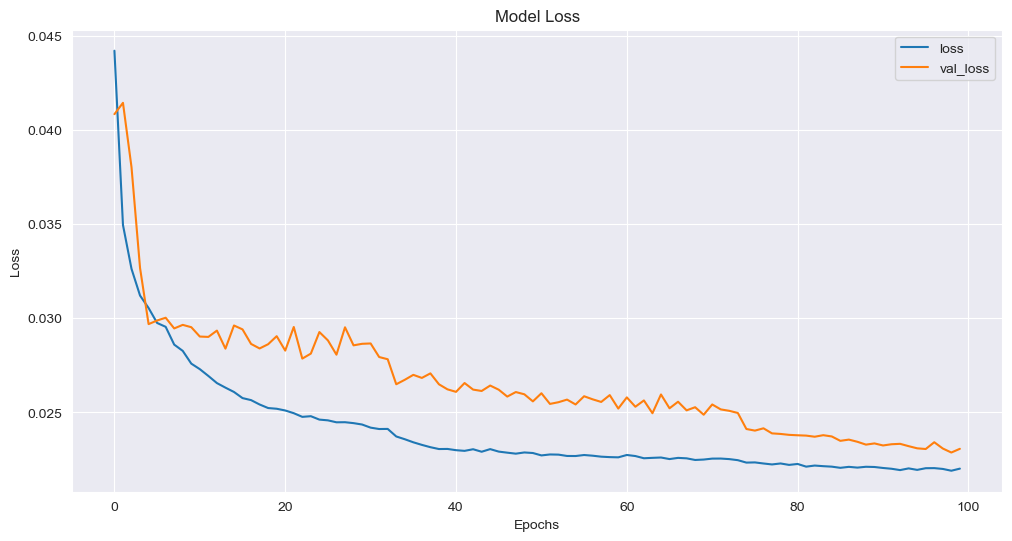

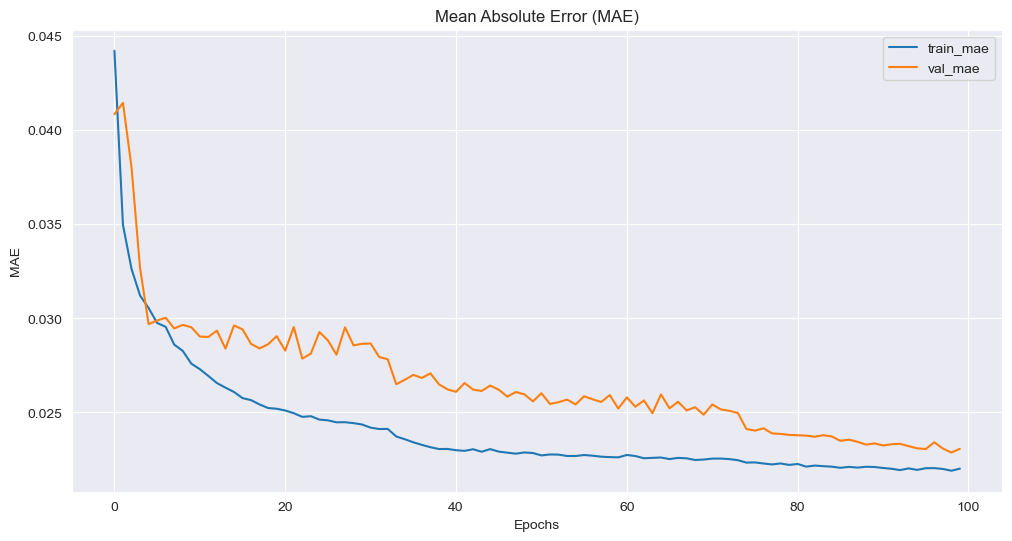

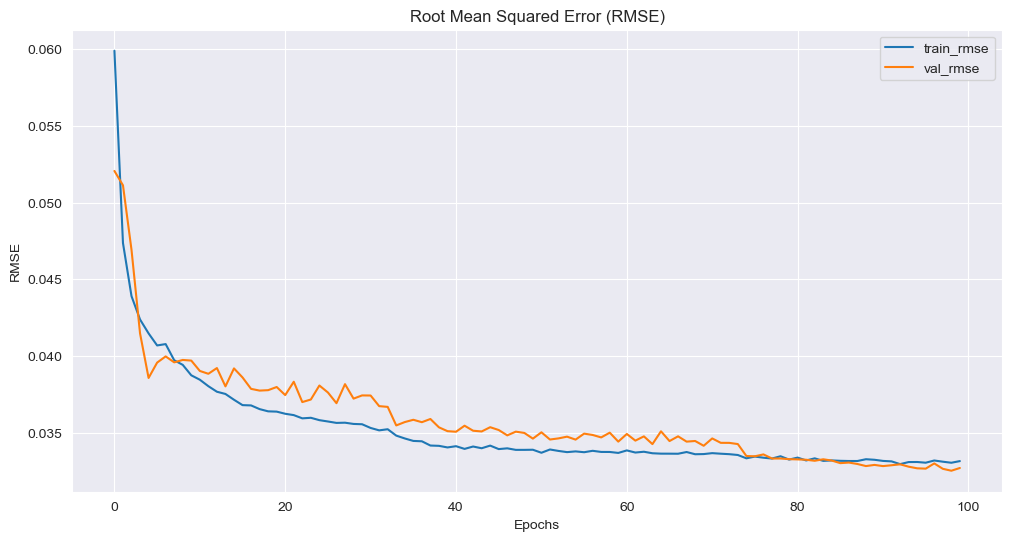

In [407]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [408]:
yhat = model.predict(test_X)

# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]

# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]

# Calculate RMSE, MAE, MAPE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
# 
# # Identify gaps in the data
# actual_vs_predicted = pd.DataFrame({
#     'hour_begins': test_df['hour_begins'],
#     'actual': inv_y,
#     'predicted': inv_yhat
# })
# 
# # Check for gaps in the hour_beginss
# actual_vs_predicted['hour_begins_diff'] = actual_vs_predicted['hour_begins'].diff().dt.total_seconds() / 3600
# gaps = actual_vs_predicted[actual_vs_predicted['hour_begins_diff'] > 1]
# 
# # Plot actual vs predicted values with gaps highlighted
# plt.figure(figsize=(20, 6))
# plt.plot(actual_vs_predicted['hour_begins'], actual_vs_predicted['actual'], label='Actual', color='blue')
# plt.plot(actual_vs_predicted['hour_begins'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
# for gap_start in gaps['hour_begins']:
#     plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
# plt.title('Actual vs Predicted Values with Gaps Highlighted')
# plt.xlabel('Time')
# plt.ylabel('Values (MW)')
# plt.legend()
# plt.grid(True)
# plt.show()
# 
# # Print the gaps and their nearest significant time differences
# print("Gaps in data:")
# for index, row in gaps.iterrows():
#     previous_hour_begins = row['hour_begins'] - pd.Timedelta(hours=row['hour_begins_diff'])
#     next_hour_begins = row['hour_begins'] + pd.Timedelta(hours=row['hour_begins_diff'])
# 
#     previous_row = actual_vs_predicted[actual_vs_predicted['hour_begins'] == previous_hour_begins]
#     next_row = actual_vs_predicted[actual_vs_predicted['hour_begins'] == next_hour_begins]
# 
#     gap_start = previous_row['hour_begins'].values[0] if not previous_row.empty else 'N/A'
#     gap_end = row['hour_begins']
# 
#     print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d %H:%M:%S%z')}")
#     print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d %H:%M:%S%z')}")
#     print(f"Time Difference: {row['hour_begins_diff']} hours\n")

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
RMSE: 19.247
MAE: 13.532
MAPE: 5.089


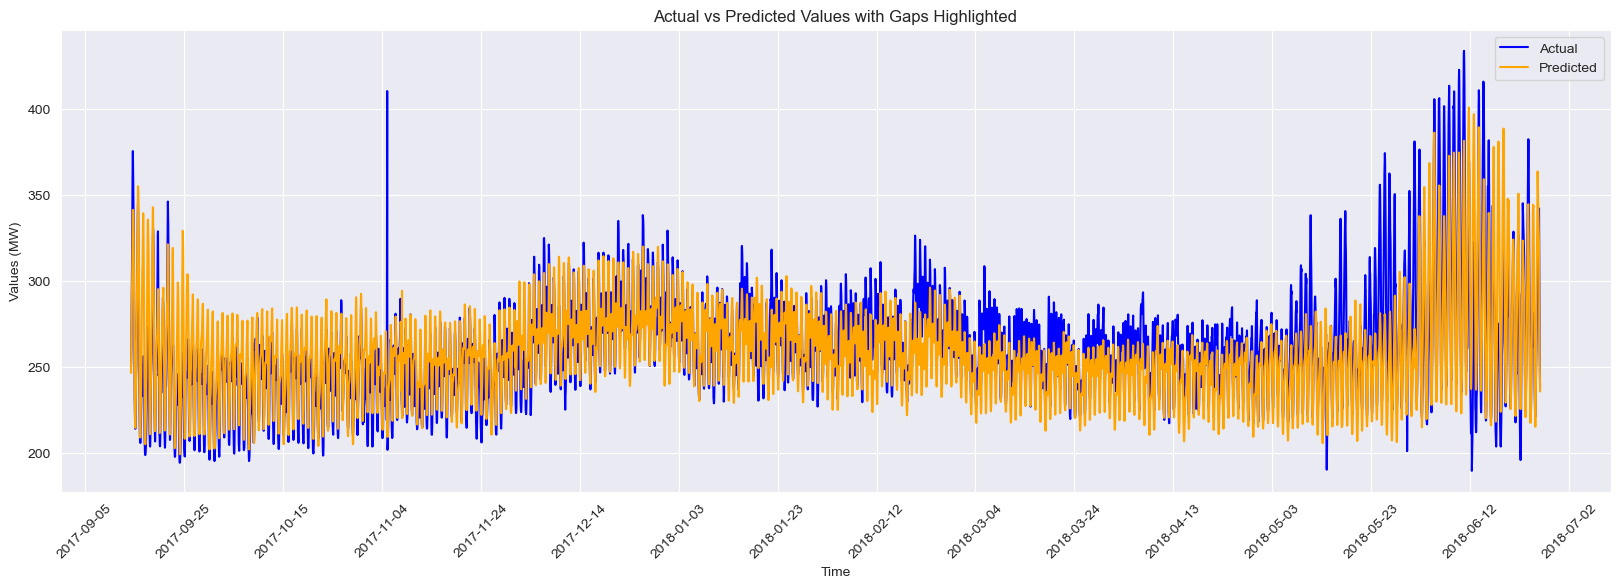

Gaps in data:


In [409]:
# Extract the test data with timestamps
test_df = LSTM_df.iloc[n_train_hours:, :].copy()
test_df['hour_begins'] = LSTM_df.iloc[n_train_hours:]['hour_begins']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'hour_begins': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['hour_begins_diff'] = actual_vs_predicted['hour_begins'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['hour_begins_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['hour_begins'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['hour_begins'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['hour_begins']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['hour_begins'] - pd.Timedelta(days=row['hour_begins_diff'])
    next_timestamp = row['hour_begins'] + pd.Timedelta(days=row['hour_begins_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['hour_begins'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['hour_begins'] == next_timestamp]

    gap_start = previous_row['hour_begins'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['hour_begins']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['hour_begins_diff']} hours\n")

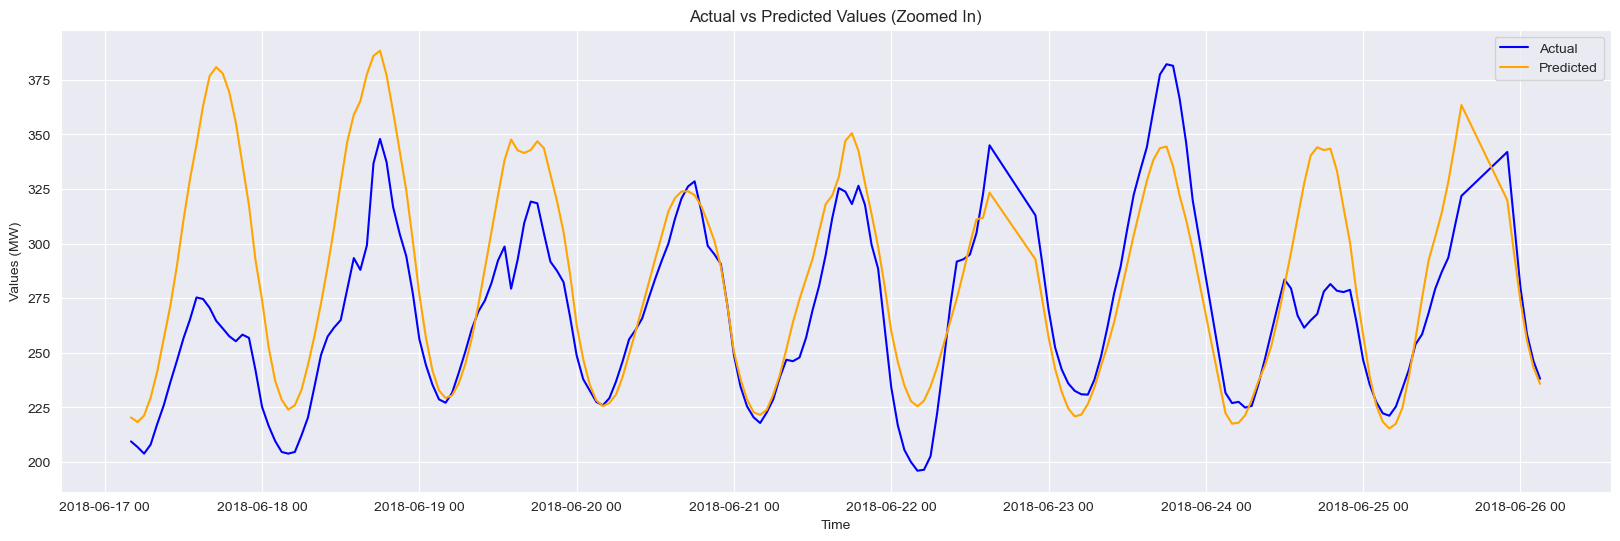

In [410]:
import matplotlib.dates as mdates

# Zoom in to plot
plt.figure(figsize=(20, 6))
plt.plot(test_timestamps[-200:], inv_y[-200:], label='Actual', color='blue')
plt.plot(test_timestamps[-200:], inv_yhat[-200:], label='Predicted', color='orange')
# Format the x-axis to show the full datetime
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
plt.title('Actual vs Predicted Values (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)
plt.show()

## Out of sample data

In [411]:
LSTM_df_ofs = LSTM_df_ofs.sort_values(by='hour_begins')
ofs_values = LSTM_df_ofs.drop(columns='hour_begins').values
ofs_hour_begins = LSTM_df_ofs['hour_begins']

# Split into input and output
ofs_X, ofs_y = ofs_values[:, :-1], ofs_values[:, -1]
# Reshape input to be 3D [number of samples, timesteps, number of features]
ofs_X = ofs_X.reshape((ofs_X.shape[0], 1, ofs_X.shape[1]))

In [412]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(27144, 1, 14) (27144,) (6787, 1, 14) (6787,)


In [413]:
# concatenate is not defined
from numpy import concatenate
# Make predictions
ofs_predictions = model.predict(ofs_X)

# Reshape OFS data to original 2D shape for inverse transformation
ofs_X_reshaped = ofs_X.reshape((ofs_X.shape[0], ofs_X.shape[2]))

# Invert scaling for forecast
inv_ofs_predictions = concatenate((ofs_X_reshaped, ofs_predictions), axis=1)
inv_ofs_predictions = scaler.inverse_transform(inv_ofs_predictions)
inv_ofs_predictions = inv_ofs_predictions[:, -1]  # First column

# Invert scaling for actual
ofs_y = ofs_y.reshape((len(ofs_y), 1))
inv_ofs_y = concatenate((ofs_X_reshaped, ofs_y), axis=1)
inv_ofs_y = scaler.inverse_transform(inv_ofs_y)
inv_ofs_y = inv_ofs_y[:, -1]  # First column

# Calculate RMSE, MAE, MAPE
ofs_rmse = sqrt(mean_squared_error(inv_ofs_y, inv_ofs_predictions))
ofs_mae = mean_absolute_error(inv_ofs_y, inv_ofs_predictions)
ofs_mape = np.mean(np.abs((inv_ofs_y - inv_ofs_predictions) / inv_ofs_y)) * 100

print('OFS RMSE: %.3f' % ofs_rmse)
print('OFS MAE: %.3f' % ofs_mae)
print('OFS MAPE: %.3f' % ofs_mape)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
OFS RMSE: 25.423
OFS MAE: 17.499
OFS MAPE: 5.695


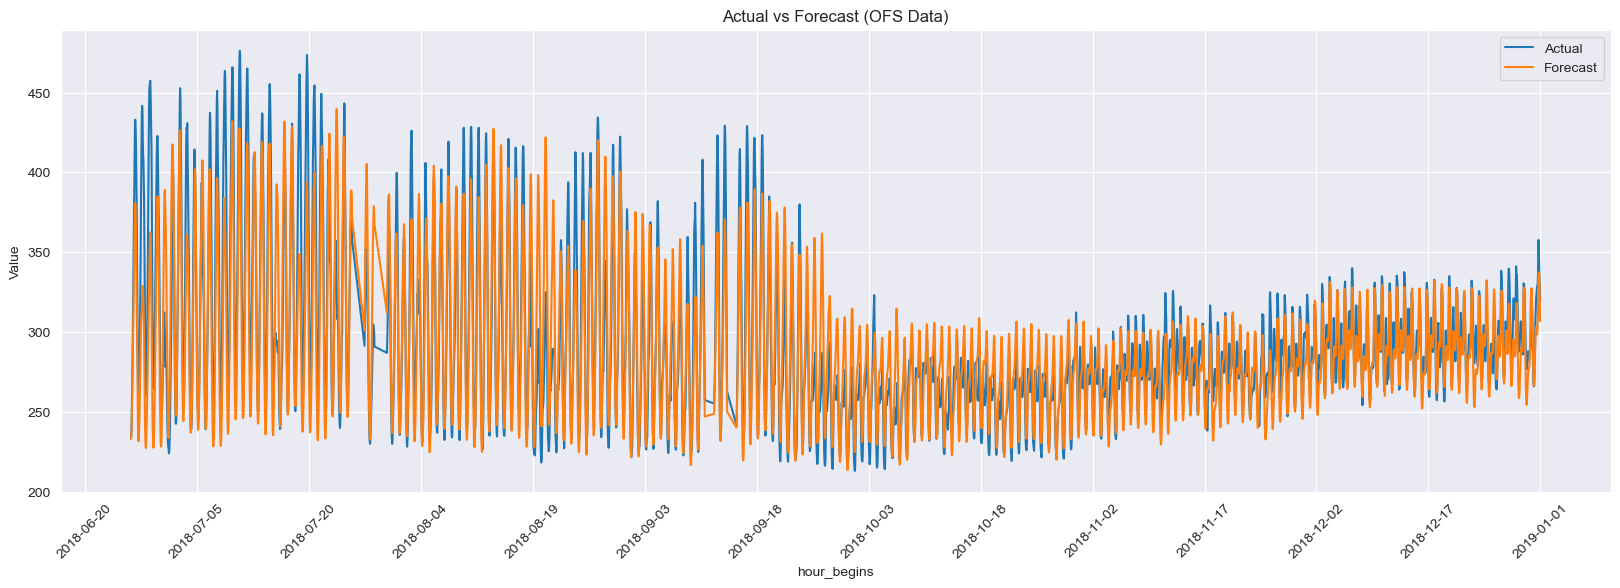

In [414]:
# Plot prediction vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(ofs_hour_begins, inv_ofs_y, label='Actual')
plt.plot(ofs_hour_begins, inv_ofs_predictions, label='Forecast')
plt.title('Actual vs Forecast (OFS Data)')
plt.ylabel('Value')
plt.xlabel('hour_begins')
plt.legend()
# Set hour_begins format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()